In [1]:
import sys
sys.path.append("./utils_library/")

import configs.default_config as cfg
import configs.local_storage_config as storage_cfg

cfg.__dict__.update(storage_cfg.__dict__)
cfg.RUN_NAME="mobilenet_model_1" #for reference 

In [2]:
from training.utils import now
nowt=now()

import cv2
import tensorflow as tf
import datetime
import numpy as np
import models.mobilenet_model as model
import matplotlib.pyplot as plt
from training import dataset_functions, callbacks, dataset_builder, load_weights, loss_metrics
import utils_library.visualization.visualizations as vis
import applications.model_wrapper
import utils_library.post_processing.post as post
import utils_library.configs.draw_config as draw_config
import utils_library.configs.post_config as post_config
import utils_library.configs.keypoints_config as kpts_config
import utils_library.configs.default_config as def_config

post.Skeletonizer.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF, post_config)
post.Skeleton.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF)

In [3]:
# Training settings
TRAINING_EPOCHS = 15
REAL_EPOCH_STEPS = int(cfg.DATASET_SIZE / cfg.BATCH_SIZE)
SHORT_EPOCH_STEPS= 50 #actual epocsh used in training, smaller than real epoch, but allows to track progress better, [in batches]
SHORT_TRAINING_EPOCHS=int(TRAINING_EPOCHS*(REAL_EPOCH_STEPS/SHORT_EPOCH_STEPS))
SHORT_VALIDATION_STEPS=5 #per short epoch

EPOCH_RATIO=int(REAL_EPOCH_STEPS / SHORT_EPOCH_STEPS)
# adam_learning_rate=0.001  #for reference
BASE_LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDUELE = np.zeros(100000)  #used with short epochs
LEARNING_RATE_SCHEDUELE[:8 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[8 * EPOCH_RATIO:13 * EPOCH_RATIO] = 0.5
LEARNING_RATE_SCHEDUELE[13 * EPOCH_RATIO:15 * EPOCH_RATIO] = 0.1
LEARNING_RATE_SCHEDUELE *= BASE_LEARNING_RATE

In [19]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

def define():
    train_model,test_model=model_maker.create_models()   
    
    #this must match the model output order
    metrics=[
              [loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]    
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
        ]
    
    train_model.compile(
                    optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE)                   
                    ,loss=loss_metrics.MaskedMeanSquaredError()
                    ,loss_weights=[5,5,5,5,1,1]
                    ,metrics=metrics                           
                   )
    
    model_path = "./trained_models/mobilenet_model_COCO/"
    mobilenet_model_COCO = tf.keras.models.load_model(model_path)
    

    for layer in test_model.layers:
        trained_layer = mobilenet_model_COCO.get_layer(layer.name)
        weights = trained_layer.get_weights()
        layer.set_weights(weights)
        
    return train_model,test_model

train_model,test_model=define()

In [9]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training
Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation
Found the following training TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training-001.tfrecords
Found the following validation TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation-001.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (

Dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


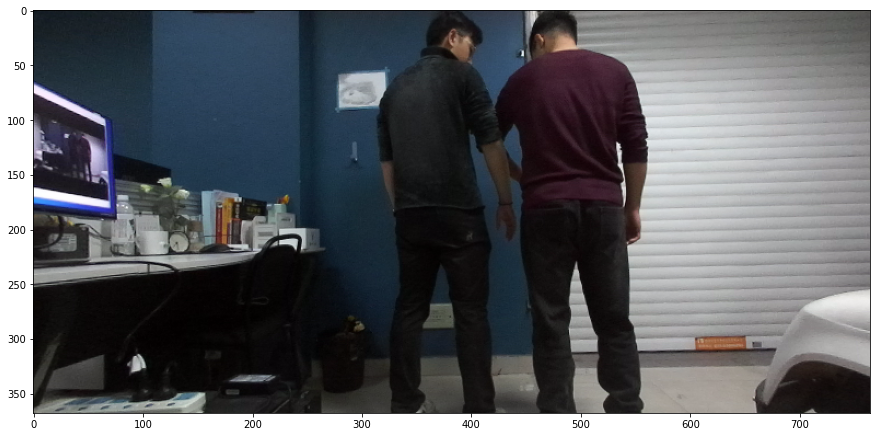

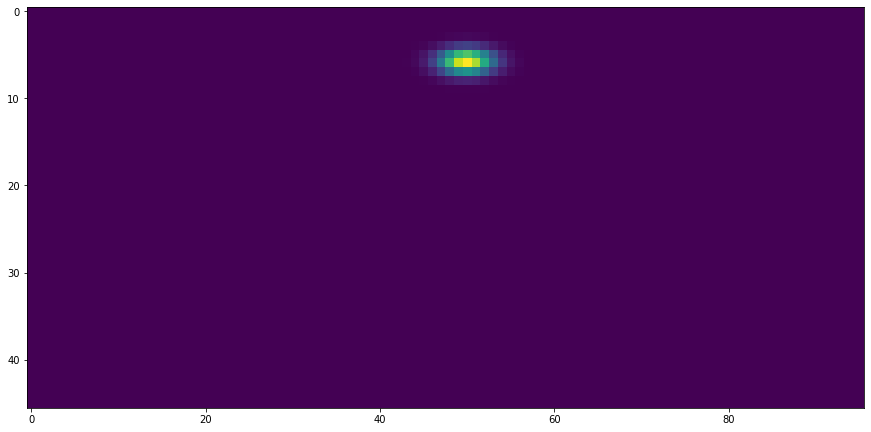

In [11]:
#Test element
print("Dataset shape:",dst) #this should match the model input, and output stages
dst_iter=iter(dst)
sample_elem=next(dst_iter)

#testing img
img = sample_elem[0][0][0,...]
plt.figure(figsize=[15,15])
plt.imshow(img)

#testing mask
m=sample_elem[1][4][0,...,0]
plt.figure(figsize=[15,15])
plt.imshow(m)

In [21]:
test_model.save('test',include_optimizer=False) 

INFO:tensorflow:Assets written to: test/assets
